# Test Technique DiaDeep

## Installation des packages

In [3]:
import pyvips
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
from skimage.io import imread, imshow
import pandas as pd

## Importation et test des pyramides TIF

In [4]:
path = "m9de8lfp.tif"
slide_geant = pyvips.Image.new_from_file(path, page=0)
print(slide_geant.width, slide_geant.height)

77824 84992


In [5]:
# load the 16x downsampled image from page 4 (2 ** 4 = 16)
slide = pyvips.Image.new_from_file(path, page=4)
print(slide.width, slide.height)

4864 5312


In [6]:
# read an image region in as a PIL Image
x, y = 100, 200
level = 2
region_width = 500
region_height = 500
region = slide.crop(x, y, region_width, region_height)

In [7]:
# convert the PIL Image to a numpy array
array = np.ndarray(
    buffer=region.write_to_memory(),
    dtype=np.uint8,
    shape=(region.height, region.width, region.bands)
)
# red, green, blue channels
print(array.shape)

(500, 500, 3)


In [8]:
# also look into pyvips.Region.fetch for faster region read
region = pyvips.Region.new(slide).fetch(x, y, region_width, region_height)

def to_array(region):
    array = np.ndarray(
        buffer=region.write_to_memory(),
        dtype=np.uint8,
        shape=(region.height, region.width, region.bands))
    return array


print(array.shape)

(500, 500, 3)


# Extract Tissue Regions

In [9]:
# load the 32x downsampled image from page 5
slide = pyvips.Image.new_from_file(path, page=5)
print(slide.width, slide.height)

2432 2656


In [10]:
#We create a function to visualize our picture
def visualisation(region):

    #Convert to an array
    array = np.ndarray(
    buffer=region.write_to_memory(),
    dtype=np.uint8,
    shape=(region.height, region.width, region.bands))

    #plot the image
    plt.imshow(array, cmap='gray')
    plt.show()

### Convert to grey image

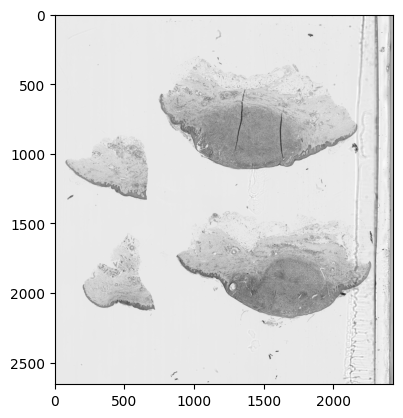

In [11]:
slide = slide.colourspace(pyvips.Interpretation.B_W)
visualisation(slide)

### Convert to binary image

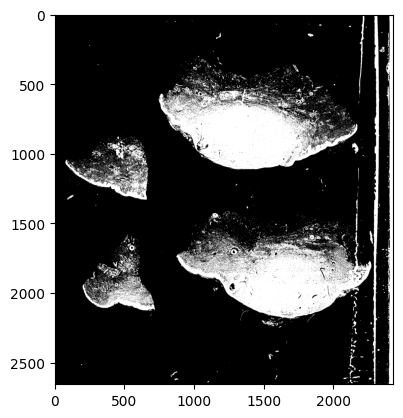

In [12]:
# Set the threshold value
threshold_value = 200
thresholded_slide = (slide > threshold_value).ifthenelse(0, 255)
visualisation(thresholded_slide)

### Apply convolution mask

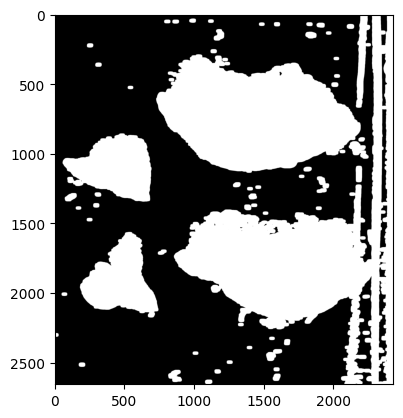

In [13]:
#We apply a mean transformation to the image to fill the blanks in the cells
mask = pyvips.Image.new_from_array(np.ones((5,8), np.uint8), scale=1)
for i in range(6): thresholded_slide = thresholded_slide.conv(mask, precision='approximate')
visualisation(thresholded_slide)

### Apply morphological transformation

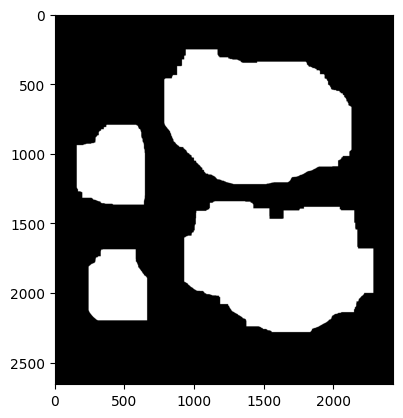

In [23]:
# Set the structuring element (a small binary image) for morphological operations

structuring_element1 = pyvips.Image.new_from_array(np.full((15,5),255, np.uint8), scale=1)
structuring_element2 = pyvips.Image.new_from_array(np.full((30, 65), 255, np.uint8), scale=1)
structuring_element3 = pyvips.Image.new_from_array(np.full((15, 15), 255, np.uint8), scale=1)

# Erode to delete small figures
for i in range(4): dilated_slide = dilated_slide.morph(structuring_element2, "erode")
# Dilate to avoid loosing a part of the cells
for i in range(15): dilated_slide = dilated_slide.morph(structuring_element3, "dilate")


# Plot the original, dilated, and eroded images
visualisation(dilated_slide)

### Visualisation of the cells

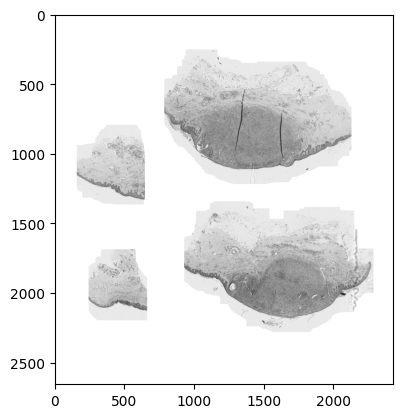

In [24]:
slide_final = (dilated_slide > 0).ifthenelse(slide, 255)
visualisation(slide_final)

### Labels creation

/home/eloi/.local/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


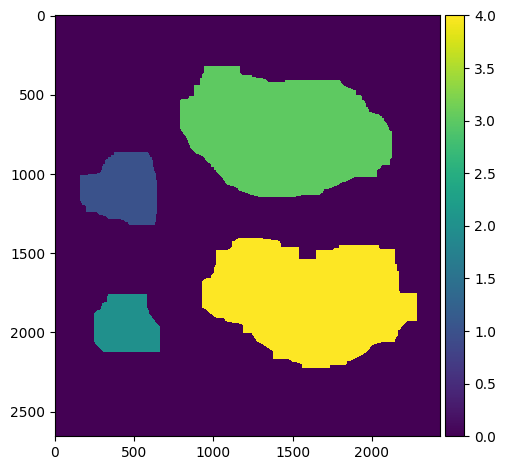

In [16]:
image = to_array(dilated_slide)
label_im = measure.label(image)
imshow(label_im)

### Creation of the png files

In [16]:
nb_region = 1
for region in measure.regionprops(label_im):
    # draw rectangle around segmented coins
    rec = region.bbox
    
    print(rec)
    png_region = slide_final.crop(rec[1], rec[0], rec[4]-rec[1], rec[3]-rec[0])

    png_region.pngsave(f'filename_{nb_region}.png')
    nb_region += 1

(865, 158, 0, 1323, 643, 1)
(1759, 243, 0, 2125, 659, 1)
(324, 786, 0, 1151, 2125, 1)
(1410, 929, 0, 2226, 2282, 1)


# Annotation

### Creation of the dataframe of annotations

In [27]:
df = pd.read_csv(open('annotations.csv'), delimiter=',')
col = df.columns

#Initialisation of our dataframe
df_real = pd.DataFrame(columns = col)

In [28]:
#We fill the first columns that are separarted with a ','
for i in range(5):
    df_real[col[i]] = df['filename'].str.split(',').str[i]

In [29]:
#We fill the url columns
for i in range(3):
    df_real[col[7+i]] = df['filename'].str.split('",').str[-1].str.split(',').str[i]

In [30]:
#We fill the two geometry columns
df_real[col[6]] = df['filename'].str.split('",').str[-2]
df_real[col[6]] = df_real[col[6]].apply(lambda x: x[13:-1])

df_real[col[5]] = df['filename'].str.split(',"').str[-2]
df_real[col[5]] = df_real[col[5]].apply(lambda x: x[12:-2])

#We create a list to store values of the geometry columns
for line in range(df_real.shape[0]):
    df_real[col[6]][line] = [list(map(int, element.split())) for element in df_real[col[6]][line].split(', ')]
    df_real[col[5]][line] = [list(map(int, element.split())) for element in df_real[col[5]][line].split(', ')]



In [31]:
#We visualise the result
df_real.head()

,filename,Annotation_ID,Annotation_Term,Area,Perimeter,WKT_geometry,opencv_geometry,us_tif_url,eu_tif_url,as_tif_url
0,m9de8lfp.tif,440864,Breslow,0.0,3.6902205896124967,"[[43664, 64272], [43152, 49520]]","[[43664, 20720], [43152, 35472]]",s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...
1,m9de8lfp.tif,440801,Normal sub-cutaneous tissue,0.0,5.712296422763127,"[[10640, 56880], [10608, 56816], [10608, 56336...","[[10640, 28112], [10608, 28176], [10608, 28656...",s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...
2,m9de8lfp.tif,440784,Normal dermis,0.0,12.489466314098886,"[[3152, 51760], [3152, 51632], [3184, 51536], ...","[[3152, 33232], [3152, 33360], [3184, 33456], ...",s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...
3,m9de8lfp.tif,440761,Normal epidermis (with papillary dermis),0.0,12.361687098401404,"[[2192, 51376], [2288, 51376], [2480, 51568], ...","[[2192, 33616], [2288, 33616], [2480, 33424], ...",s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...
4,m9de8lfp.tif,440671,Normal epidermis (with papillary dermis),0.0,11.4800058201831,"[[5536, 23072], [5792, 23072], [5984, 23008], ...","[[5536, 61920], [5792, 61920], [5984, 61984], ...",s3://drivendata-competition-visiomel-public-us...,s3://drivendata-competition-visiomel-public-eu...,s3://drivendata-competition-visiomel-public-as...


### Creation of the masks of the annotations

In [32]:
import skimage.draw as sk
import math

In [33]:
df_copy = df_real.copy()

In [34]:
image = slide_final.copy()

In [35]:
for line in range(df_copy.shape[0]):
    #the values of the dataframe are for the non downscaled image. We change the values to fit them in a 32x downscaled image.
    #We inverse the height axis because wkt starts in the bottom left corner
    df_copy[col[5]][line] = [[math.floor((slide_geant.height - element[1])/32), math.floor((element[0])/32)] for element in df_real[col[5]][line]]
    

In [76]:
#We create a liste of all annotation terms
id = df_copy['Annotation_Term'].unique()

#We create an empty mask
image_masks = pyvips.Image.black(image.width, image.height, bands=1)

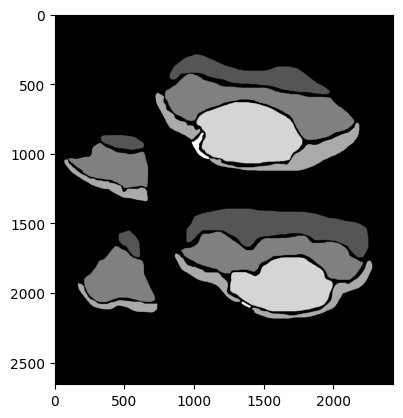

In [83]:
for i in range(1, df_copy.shape[0]):
    #Creation of the mask
    mask = sk.polygon2mask((dilated_slide.width, dilated_slide.height), df_copy.loc[i, 'WKT_geometry'])
    mask.astype(int)
    mask = pyvips.Image.new_from_array(mask)

    #We select the annotation term of the selected mask
    annotation = df_copy.loc[i, 'Annotation_Term']

    #We add the mask to the image
    id_mask = np.where(id == annotation)[0][0] + 1 #+1 because 0 is the background
    image_masks = image_masks.draw_mask(id_mask, mask, 0, 0)

visualisation(image_masks)

For each cell we found earlier we create a png of the same dimension where each anoted pixel has the value of the annotation term id

In [84]:
nb_region = 1
for region in measure.regionprops(label_im):
    # draw rectangle around segmented labels
    rec = region.bbox
    png_region = image_masks.crop(rec[1], rec[0], rec[4]-rec[1], rec[3]-rec[0])

    #save the mask
    png_region.pngsave(f'mask_{nb_region}.png')
    nb_region += 1

# Creation of the model

In [1]:
import segmentation_models_pytorch as smp

net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=nb_masks,               # model output channels (number of classes in your dataset)
)

ModuleNotFoundError: No module named 'segmentation_models_pytorch'